In [9]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import math
import imageio

import llops.operators as ops
import llops as yp
import llops.simulation as sim
from llops import vec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
global_backend = 'arrayfire' # arrayfire or numpy
global_dtype = 'complex32' # complex32 or complex64

ops.setDefaultBackend(global_backend)
ops.setDefaultDatatype(global_dtype)

<IPython.core.display.Javascript object>


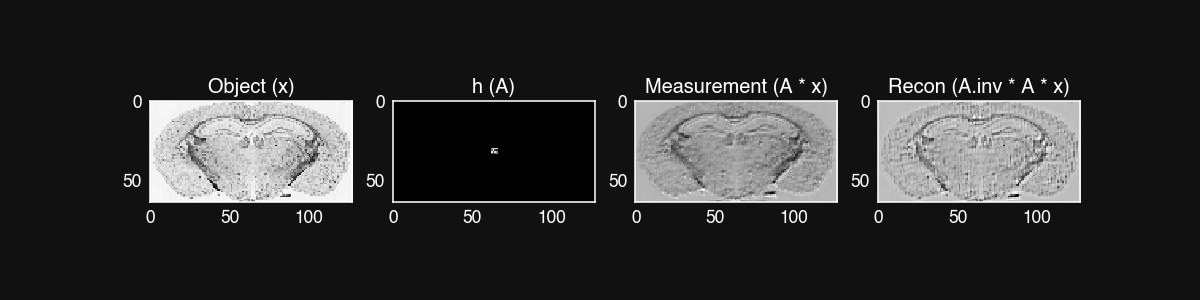

In [11]:
# Image size to simulate
image_size = np.array([64, 128])

# Determine machine precision threshold
eps = yp.precision(global_dtype) * np.prod(image_size)

# Load object and crop to size
x = sim.brain(image_size)

# Generate convolution kernel h
h_size = np.array([4, 4])
h = yp.zeros(image_size, global_dtype, global_backend)
h[image_size[0] // 2 - h_size[0] // 2:image_size[0] // 2 + h_size[0] // 2,
  image_size[1] // 2 - h_size[1] // 2:image_size[1] // 2 + h_size[1] // 2] = yp.randn((h_size[0], h_size[1]), global_dtype, global_backend)

h /= yp.scalar(yp.sum(yp.abs(h)))

# Forward Operator
A = ops.Convolution(h, mode='circular', pad_value='mean', invalid_support_value=0)
A.inverse_regularizer = 1e-2

# Generate Measurement
y = A * x

# Reconstruction
x_star = A.inv * y

# Show object and h
plt.figure(figsize=(12,3))
plt.subplot(141)
plt.imshow(yp.abs(yp.changeBackend(x, 'numpy')), cmap='gray')
plt.title('Object (x)')
plt.subplot(142)
plt.imshow(yp.abs(np.asarray(h)), cmap='gray')
plt.title('h (A)')
plt.subplot(143)
plt.imshow((yp.abs(np.asarray(y))), cmap='gray')
plt.title('Measurement (A * x)');
plt.subplot(144)
plt.imshow((yp.abs(np.asarray(x_star))), cmap='gray')
plt.title('Recon (A.inv * A * x)');

<IPython.core.display.Javascript object>


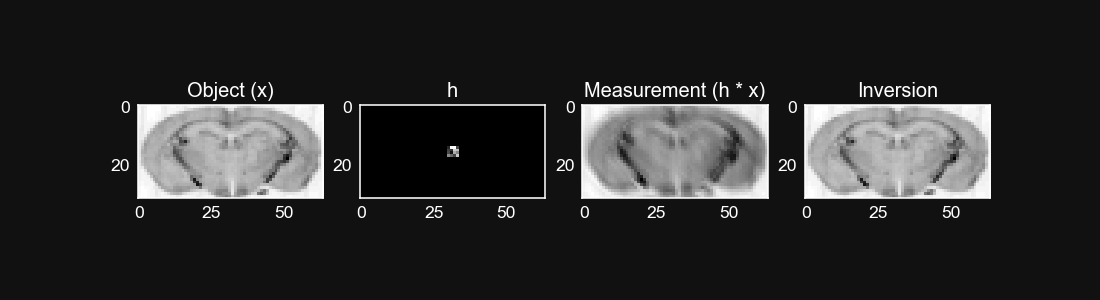

In [6]:
C = ops.Convolution(h, pad_value='mean')
A = C
y = A * x

# Show object and h
plt.figure(figsize=(11,3))
plt.subplot(141)
plt.imshow(yp.abs(yp.changeBackend(x_0, 'numpy')))
plt.title('Object (x)')
plt.subplot(142)
plt.imshow(yp.abs(np.asarray(h)))
plt.title('h')
plt.subplot(143)
plt.imshow((yp.abs(np.asarray(y))))
plt.title('Measurement (h * x)');
plt.subplot(144)
plt.imshow((yp.abs(np.asarray(A.inv * y))))
plt.title('Inversion');

# Function-based convolution

<IPython.core.display.Javascript object>


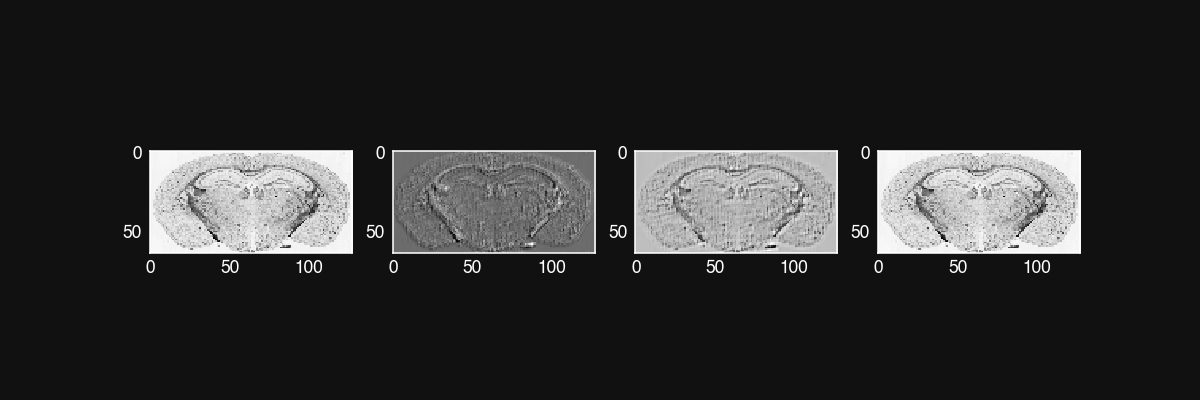

In [12]:
conv_func, conv_adj_func, conv_inv_func, _ = yp.fft.conv_functions(yp.shape(x), h, mode='same', pad_convolution=False, pad_fft=True)

plt.figure()
plt.subplot(141)
plt.imshow(yp.real(x))
plt.subplot(142)
plt.imshow(yp.real(conv_func(x)))
plt.subplot(143)
plt.imshow(yp.real(conv_adj_func(conv_func(x))))
plt.subplot(144)
plt.imshow(yp.real(conv_inv_func(conv_func(x), regularization=1e-8)))

# Function Shortcut-based convolution

<IPython.core.display.Javascript object>


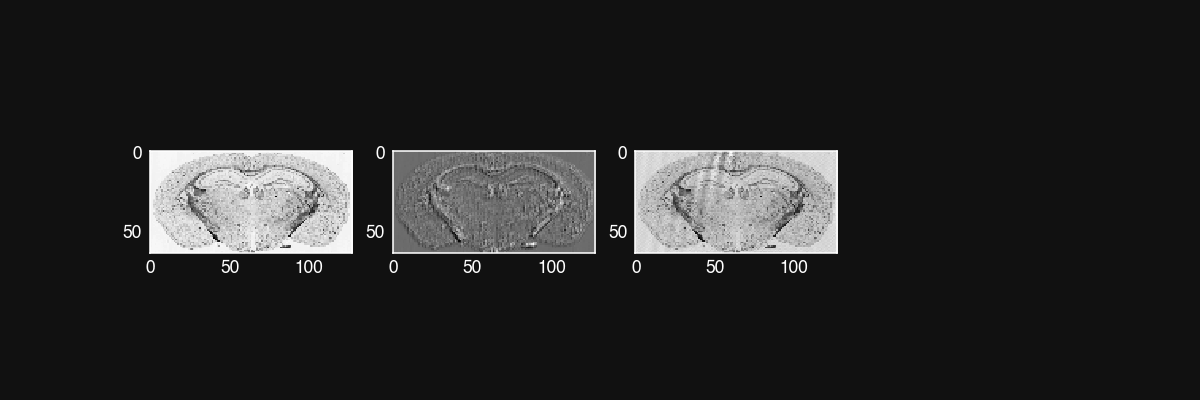

In [13]:
plt.figure()
plt.subplot(141)
plt.imshow(yp.real(x))
plt.subplot(142)
plt.imshow(yp.real(yp.convolve(x, h)))
plt.subplot(143)
plt.imshow(yp.real(yp.deconvolve(yp.convolve(x, h),h)))

## Arrayfire Builtin Convolution

<IPython.core.display.Javascript object>


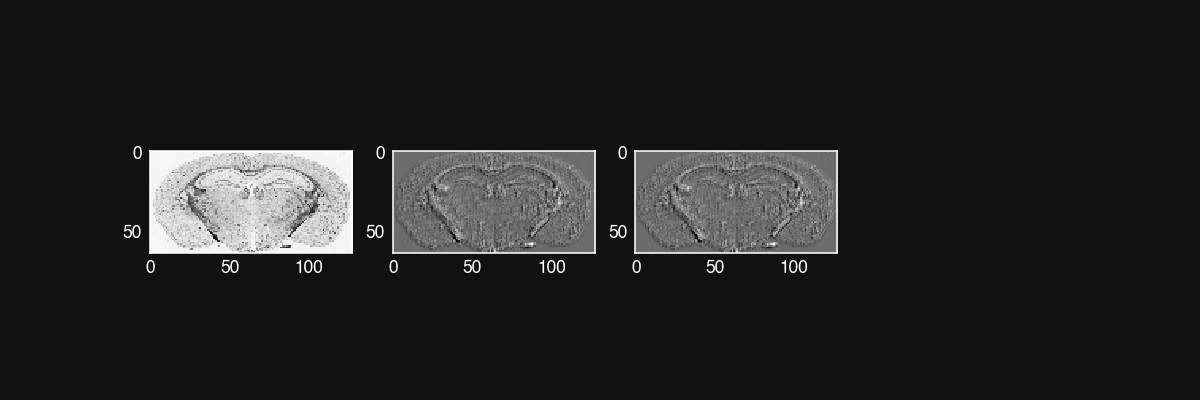

In [14]:
import arrayfire as af

pad_size = [sh + 16 for sh in yp.shape(x)]

xp = yp.pad(x, pad_size, center=True, pad_value='edge')
hp = yp.pad(h, pad_size, center=True, pad_value='edge')
xh = yp.crop(yp.real(af.signal.convolve2(xp, hp)), yp.shape(x), center=True)
plt.figure()
plt.subplot(141)
plt.imshow(yp.real(x))
plt.subplot(142)
plt.imshow(xh)
plt.subplot(143)
plt.imshow(yp.real(xh - yp.convolve(x, h)))